# Customer Churn Data

This dataset is randomly collected from an Iranian telecom companyâ€™s database over a period of 12 months. A total of 3150 rows of data, each representing a customer, bear information for 13 columns. The attributes that are in this dataset
are call failures, frequency of SMS, number of complaints, number of distinct calls, subscription length, age group, the charge amount, type of service, seconds of use, status, frequency of use, and Customer Value.

All of the attributes except for attribute churn is the aggregated data of the first 9 months. The churn labels are the state of the customers at the end of 12 months. The three months is the designated planning gap.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [4]:
df = pd.read_csv('Customer Churn.csv')
df.head()

Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2            1       2   25   
2                       24          3            1       1   30   
3                       35          1            1       1   15   
4                       33          1            1       1   15   

   Customer Value  Churn  
0         197.640      0  
1          46.035      0  
2        1536.520      0  
3         240.020      0  
4         145.805      0

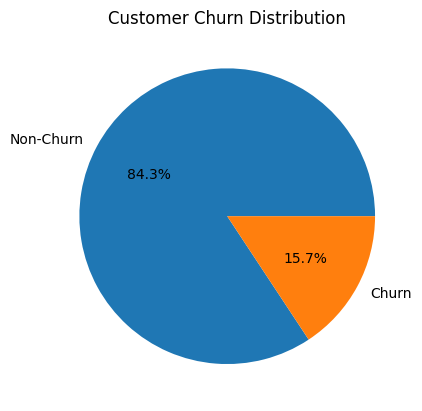

In [5]:
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index.map({1: 'Churn', 0: 'Non-Churn'}), autopct='%1.1f%%')
plt.title('Customer Churn Distribution')
plt.show()

# Data Exploration and Preprocessing

### Understanding the Dataset Structure

In [6]:
df.dtypes

Call  Failure                int64
Complains                    int64
Subscription  Length         int64
Charge  Amount               int64
Seconds of Use               int64
Frequency of use             int64
Frequency of SMS             int64
Distinct Called Numbers      int64
Age Group                    int64
Tariff Plan                  int64
Status                       int64
Age                          int64
Customer Value             float64
Churn                        int64
dtype: object

In [7]:
df.shape

(3150, 14)

In [8]:
df.columns

Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')

In [9]:
df.rename(columns={'Call  Failure': 'Call Failures', 'Subscription  Length': 'Subscription Length',
                   'Charge  Amount': 'Charge Amount', 'Frequency of use': 'Frequency of Use'}, inplace=True)
df.columns

Index(['Call Failures', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')

In [10]:
# Check for missing values
print(df.isnull().sum())

Call Failures              0
Complains                  0
Subscription Length        0
Charge Amount              0
Seconds of Use             0
Frequency of Use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64


### Additional Variable Information

1.   Anonymous Customer ID

2.   Call Failures: number of call failures

3.   Complains: binary (0: No complaint, 1: complaint)

4.   Subscription Length: total months of subscription

5.   Charge Amount: Ordinal attribute (0: lowest amount, 9: highest amount)

6.   Seconds of Use: total seconds of calls

7.   Frequency of use: total number of calls

8.   Frequency of SMS: total number of text messages

9.   Distinct Called Numbers: total number of distinct phone calls

10.  Age Group: ordinal attribute (1: younger age, 5: older age)

11.  Tariff Plan: binary (1: Pay as you go, 2: contractual)

12.  Status: binary (1: active, 2: non-active)

13.  Churn: binary (1: churn, 0: non-churn) - Class label

14.  Customer Value: The calculated value of customer

# Data Preprocessing

The data set contains two variables for customer 'Age' and 'Age Group'. Since having one variable would be enough and it is easy to find relationships among the same age group than the specific age of the customer, we can drop the 'Age' variable as it does not provide any new information to model but it can introduce overfitting to the model.

In [11]:
df.drop('Age', axis=1, inplace=True)
df.describe()

Call Failures    Complains  Subscription Length  Charge Amount  \
count    3150.000000  3150.000000          3150.000000    3150.000000   
mean        7.627937     0.076508            32.541905       0.942857   
std         7.263886     0.265851             8.573482       1.521072   
min         0.000000     0.000000             3.000000       0.000000   
25%         1.000000     0.000000            30.000000       0.000000   
50%         6.000000     0.000000            35.000000       0.000000   
75%        12.000000     0.000000            38.000000       1.000000   
max        36.000000     1.000000            47.000000      10.000000   

       Seconds of Use  Frequency of Use  Frequency of SMS  \
count     3150.000000       3150.000000       3150.000000   
mean      4472.459683         69.460635         73.174921   
std       4197.908687         57.413308        112.237560   
min          0.000000          0.000000          0.000000   
25%       1391.250000         27.000000          6.000000   
50%       2990.000000         54.000000         21.000000   
75%       6478.250000         95.000000         87.000000   
max      17090.000000        255.000000        522.000000   

       Distinct Called Numbers    Age Group  Tariff Plan       Status  \
count              3150.000000  3150.000000  3150.000000  3150.000000   
mean                 23.509841     2.826032     1.077778     1.248254   
std                  17.217337     0.892555     0.267864     0.432069   
min                   0.000000     1.000000     1.000000     1.000000   
25%                  10.000000     2.000000     1.000000     1.000000   
50%                  21.000000     3.000000     1.000000     1.000000   
75%                  34.000000     3.000000     1.000000     1.000000   
max                  97.000000     5.000000     2.000000     2.000000   

       Customer Value        Churn  
count     3150.000000  3150.000000  
mean       470.972916     0.157143  
std        517.015433     0.363993  
min          0.000000     0.000000  
25%        113.801250     0.000000  
50%        228.480000     0.000000  
75%        788.388750     0.000000  
max       2165.280000     1.000000

In [12]:
# Identify numerical columns
numerical_cols = ['Call Failures', 'Subscription Length', 'Seconds of Use', 'Frequency of Use',
                  'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical features
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display the processed DataFrame
df.head()

Call Failures  Complains  Subscription Length  Charge Amount  \
0       0.051229          0             0.636726              0   
1      -1.050285          0             0.753384              0   
2       0.326608          0             0.520069              0   
3       0.326608          0             0.636726              0   
4      -0.637217          0             0.636726              0   

   Seconds of Use  Frequency of Use  Frequency of SMS  \
0       -0.024411          0.026816         -0.607513   
1       -0.989807         -1.122926         -0.589691   
2       -0.481140         -0.164807          2.547012   
3       -0.065390         -0.060285         -0.643157   
4       -0.495435         -0.199648         -0.634246   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Customer Value  \
0                -0.378158          3            1       1       -0.528759   
1                -1.133331          2            1       2       -0.822036   
2                 0.028473          3            1       1        2.061285   
3                 0.667466          1            1       1       -0.446775   
4                 0.551285          1            1       1       -0.629033   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

# Exploratory Data Analysis (EDA)

### Explore the Distribution of Categorical Features

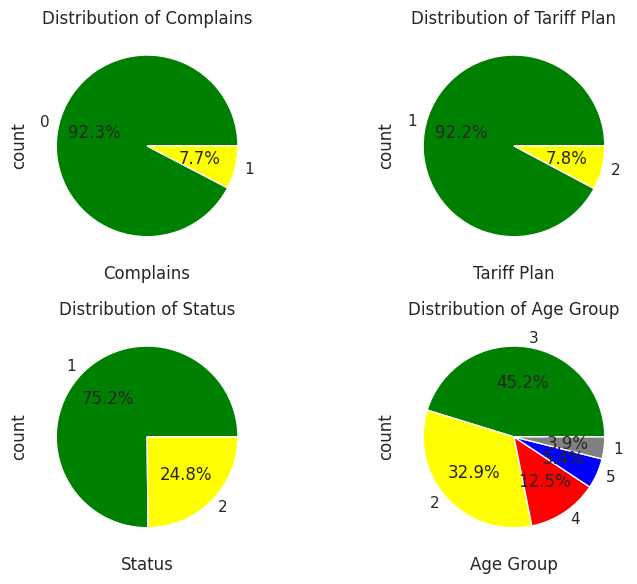

In [13]:
categorical_cols = ['Complains', 'Tariff Plan', 'Status', 'Age Group']

# Set the style of the visualizations
sns.set(style="whitegrid")

# Plot the distribution of categorical features
plt.figure(figsize=(8, 6))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    colors = ['green', 'yellow', 'red', 'blue', 'grey']
    df[col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### Explore the Distribution of Numerical Features

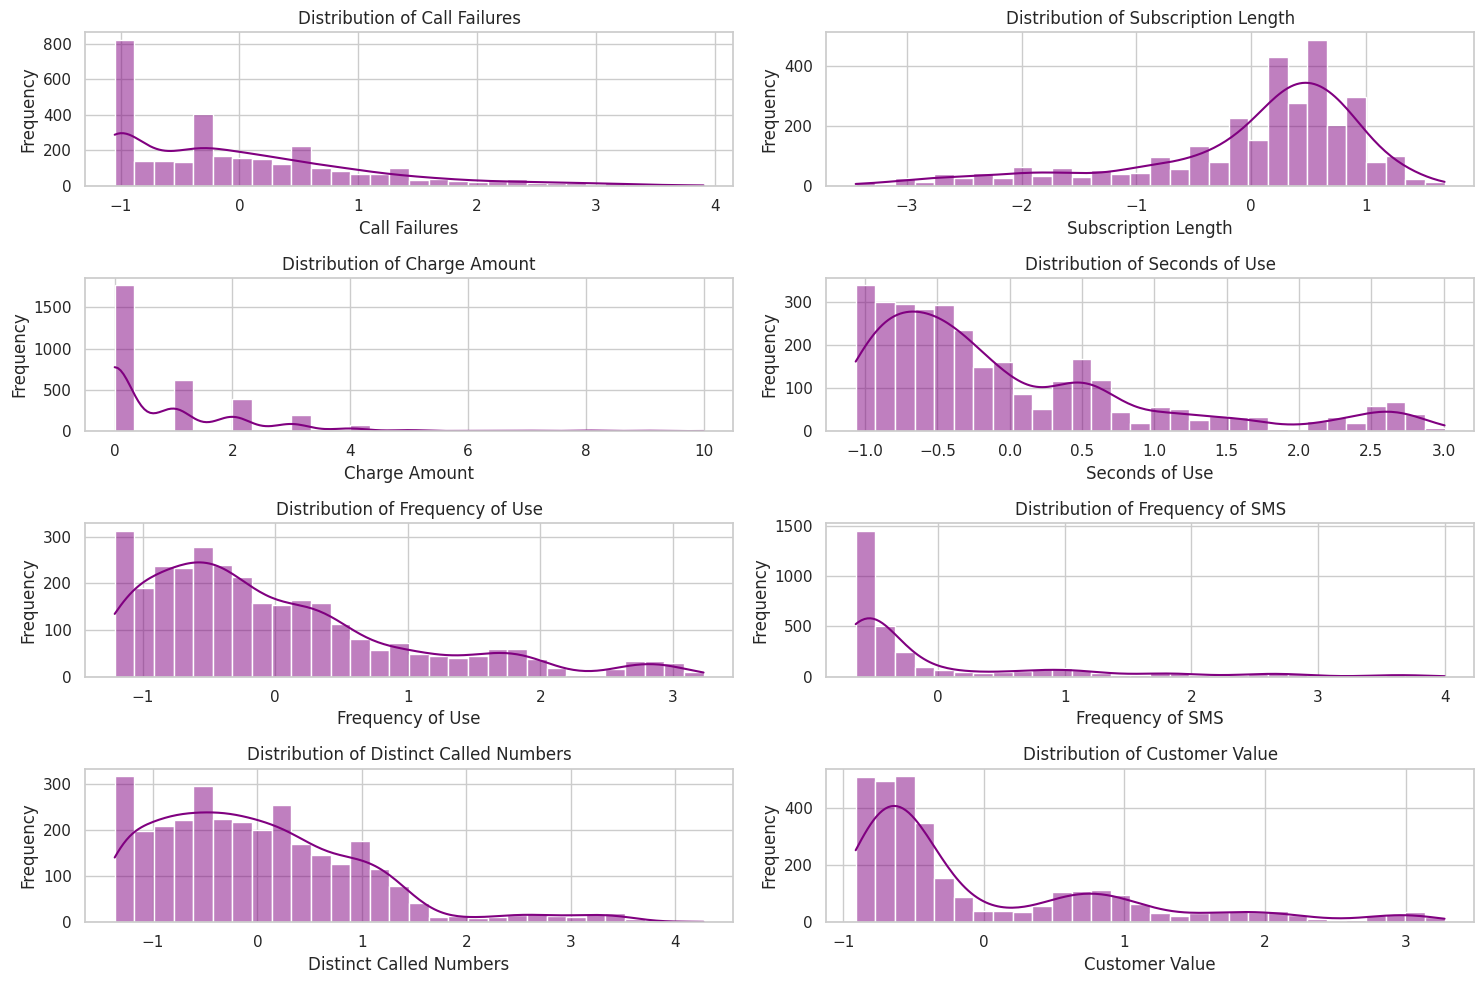

In [14]:
numerical_cols = ['Call Failures', 'Subscription Length', 'Charge Amount', 'Seconds of Use',
                  'Frequency of Use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']

# Determine the number of rows and columns for the subplots
n_cols = 2
n_rows = (len(numerical_cols) + 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the distribution of numerical features
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color='purple')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

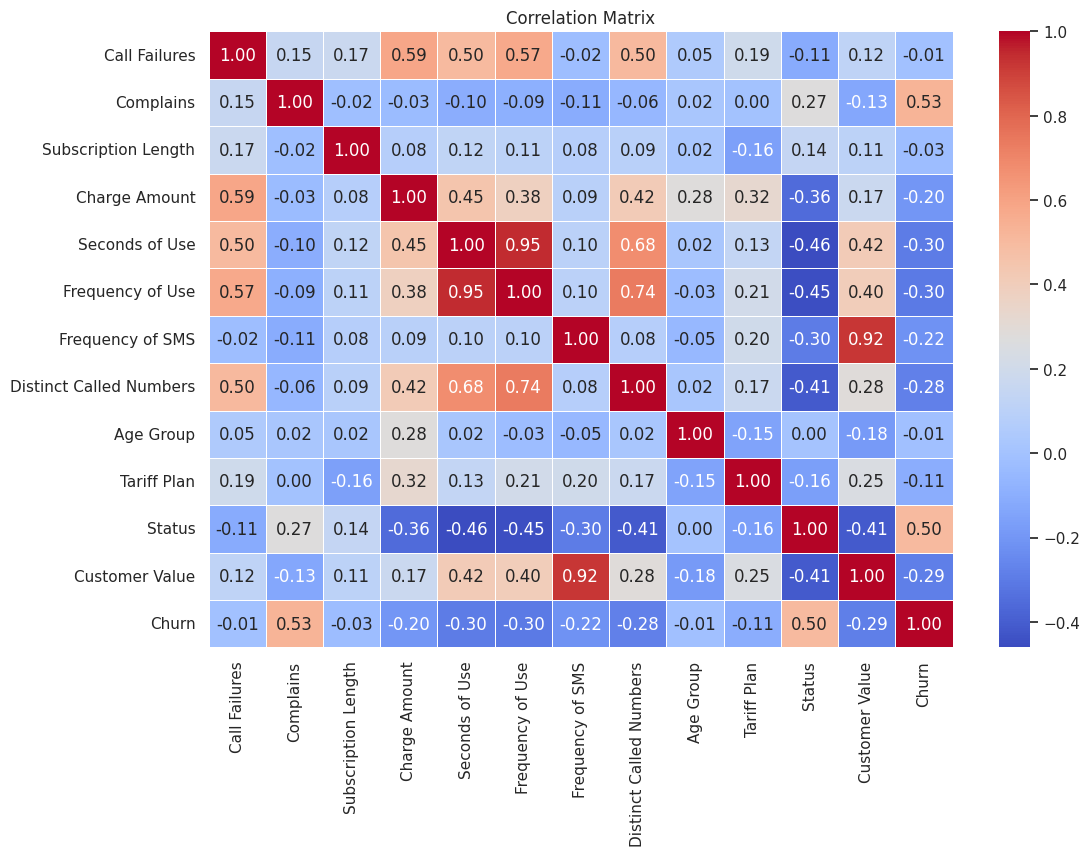

In [15]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

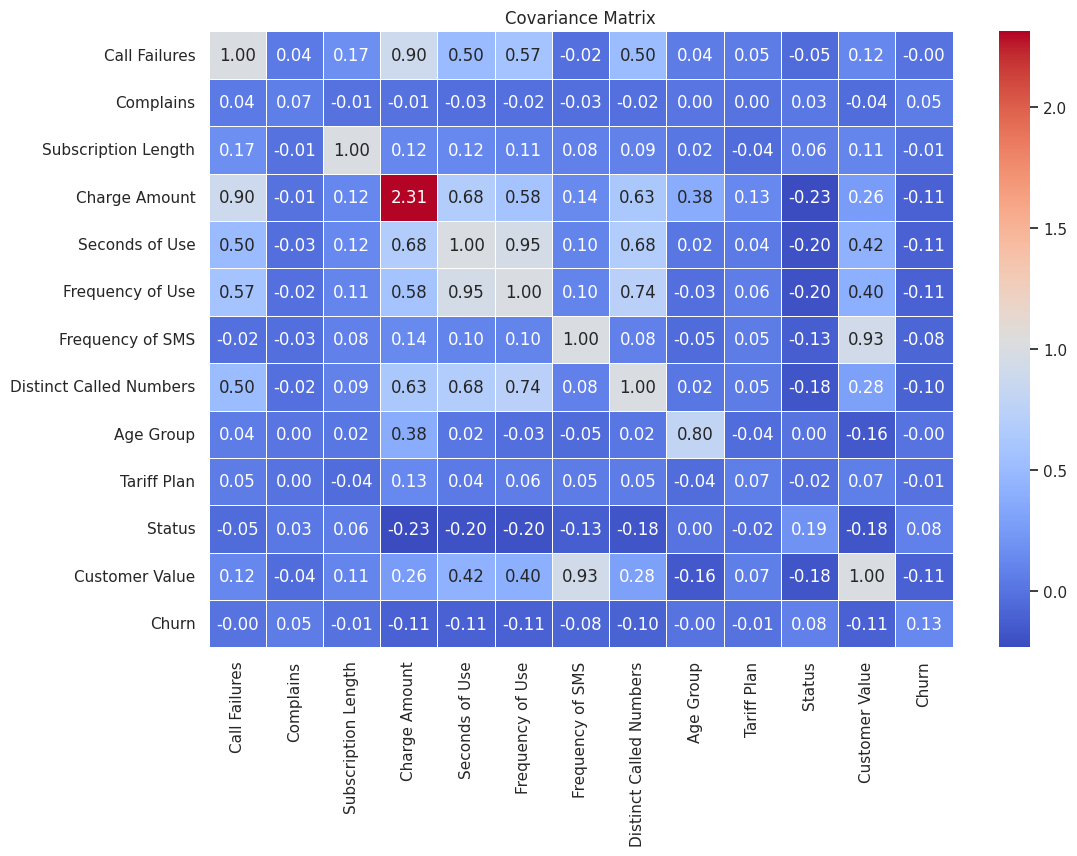

In [16]:
# Calculate the correlation matrix
cov_matrix = df.cov()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Covariance Matrix')
plt.show()

### Analyze Relationships Between Variables

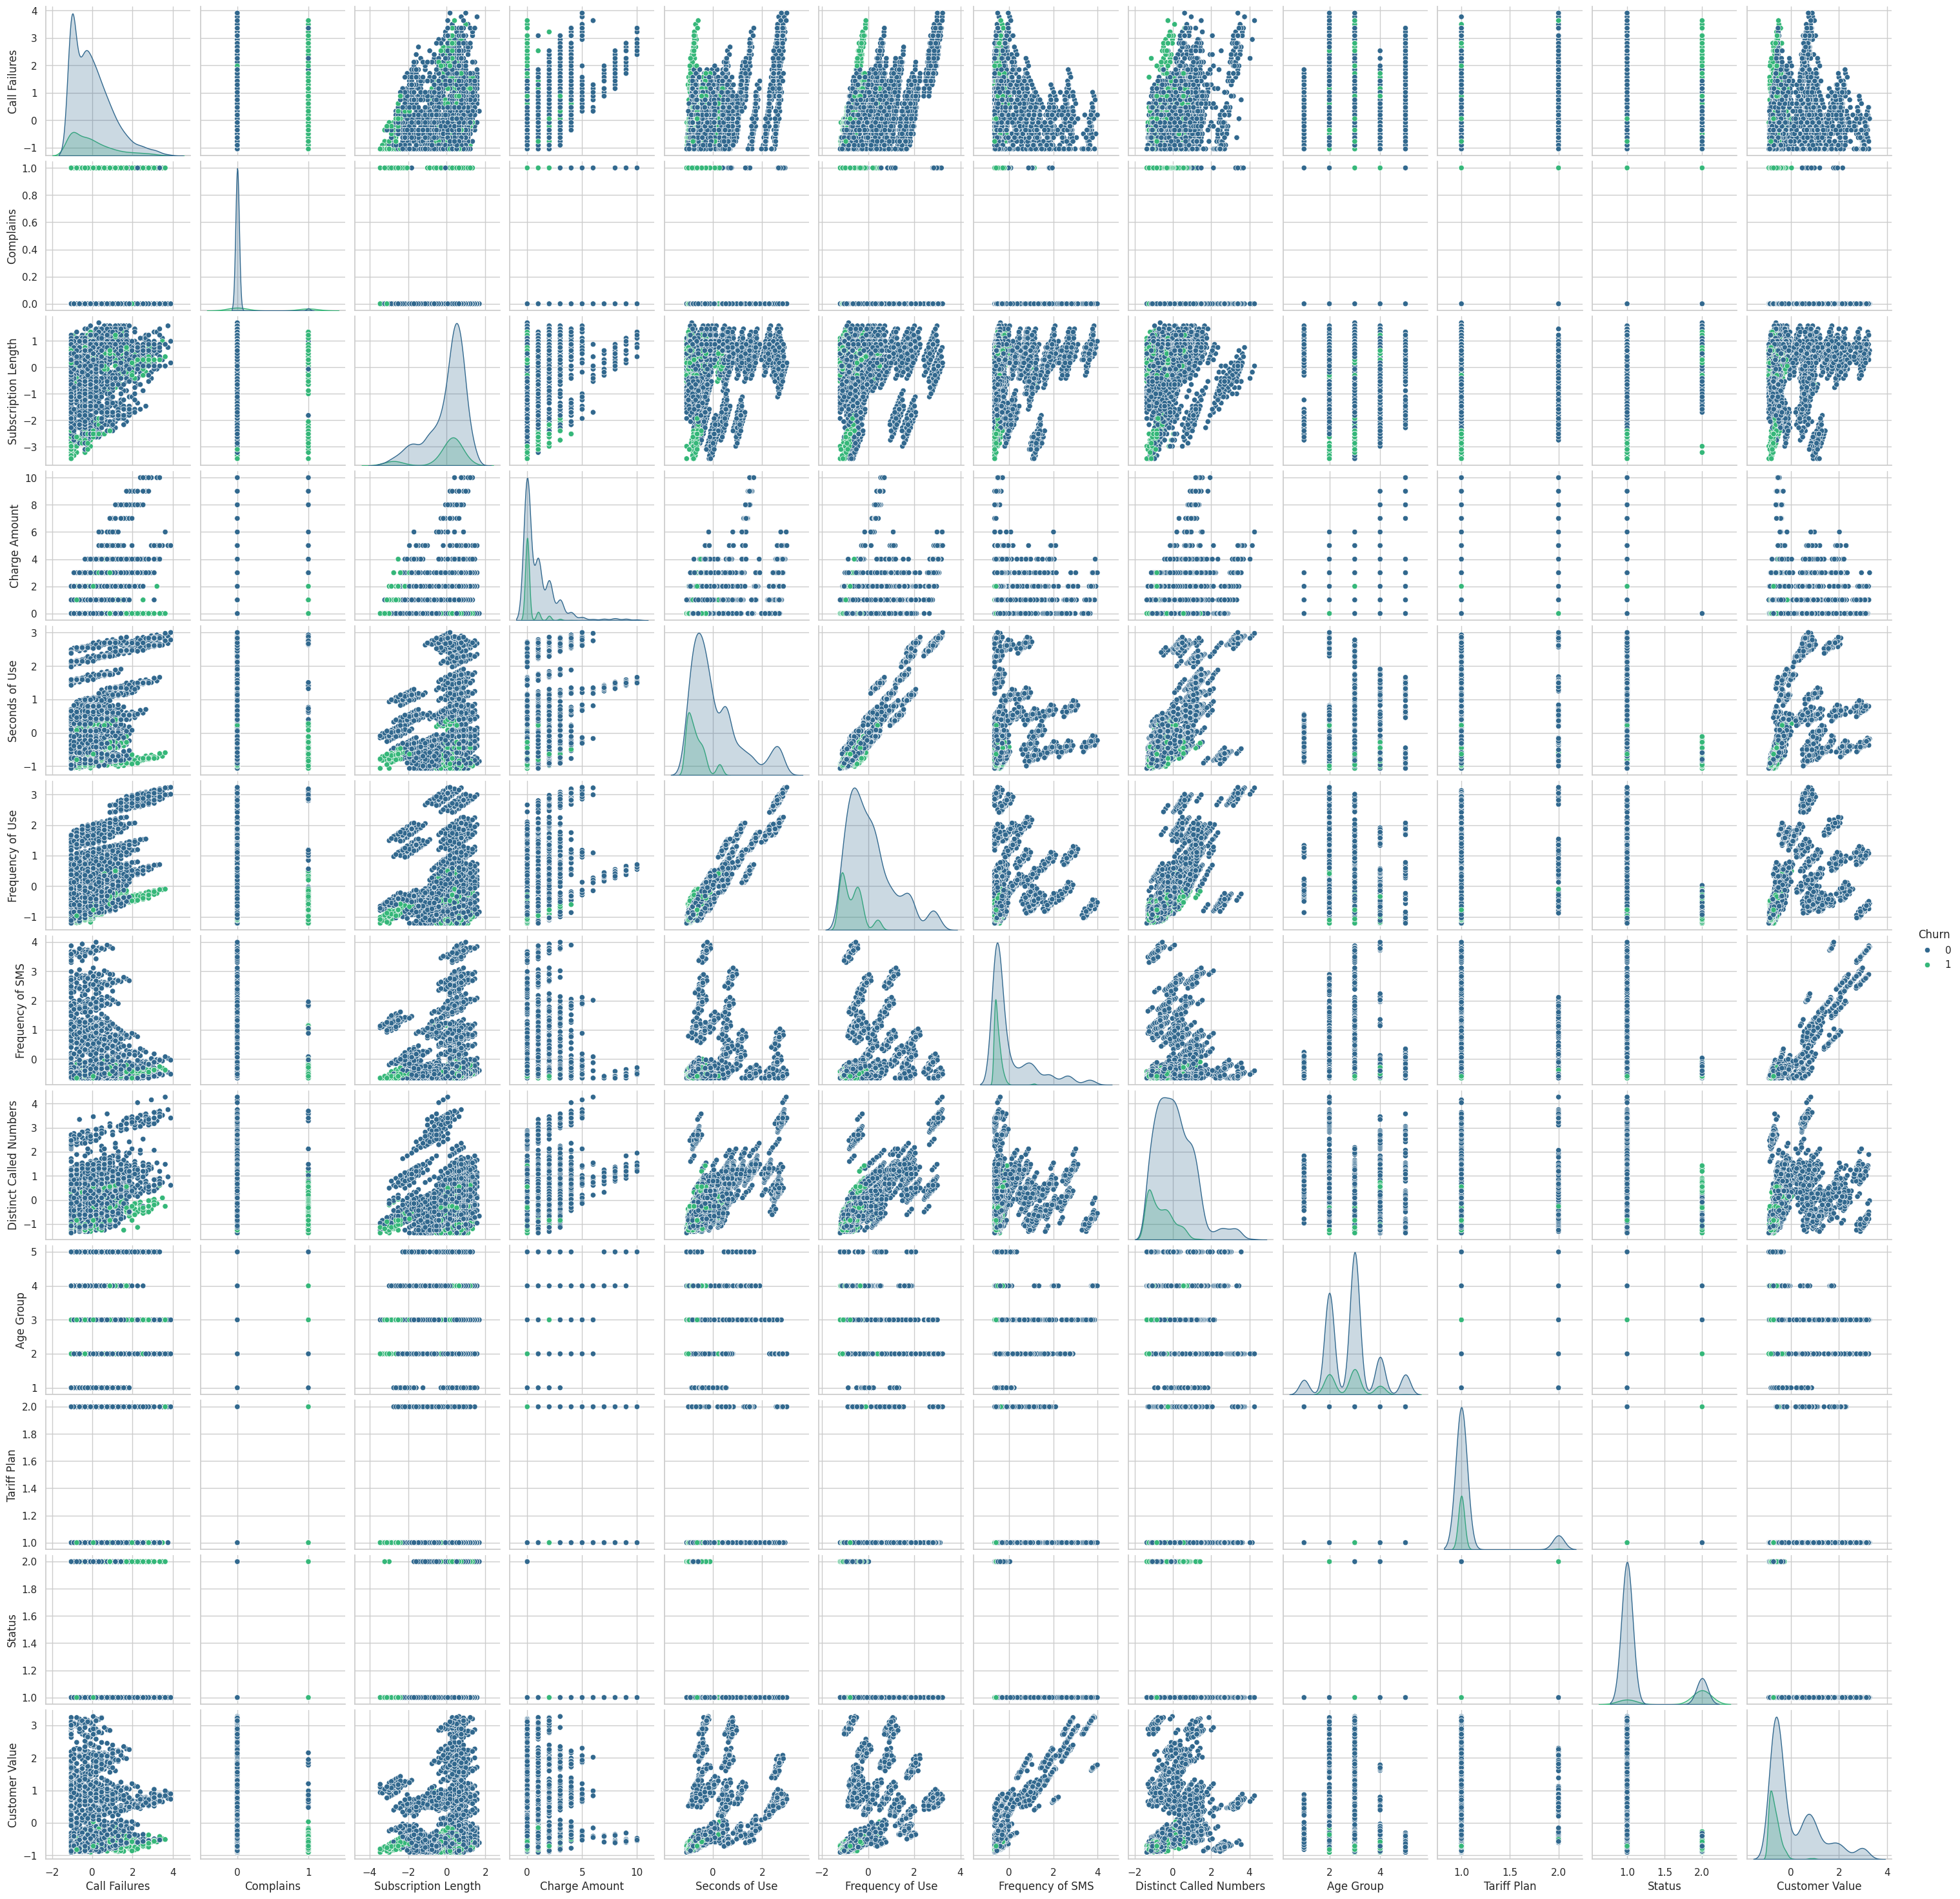

In [17]:
# Plot pair plot for numerical features
sns.pairplot(df, hue='Churn', diag_kind='kde', palette='viridis')
plt.show()

<ipython-input-18-0fbc5b7293bc>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=col, ax=axes[i], palette='viridis')
<ipython-input-18-0fbc5b7293bc>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=col, ax=axes[i], palette='viridis')
<ipython-input-18-0fbc5b7293bc>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=col, ax=axes[i], palette='viridis')
<ipython-input-18-0fbc5b7293bc>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remove

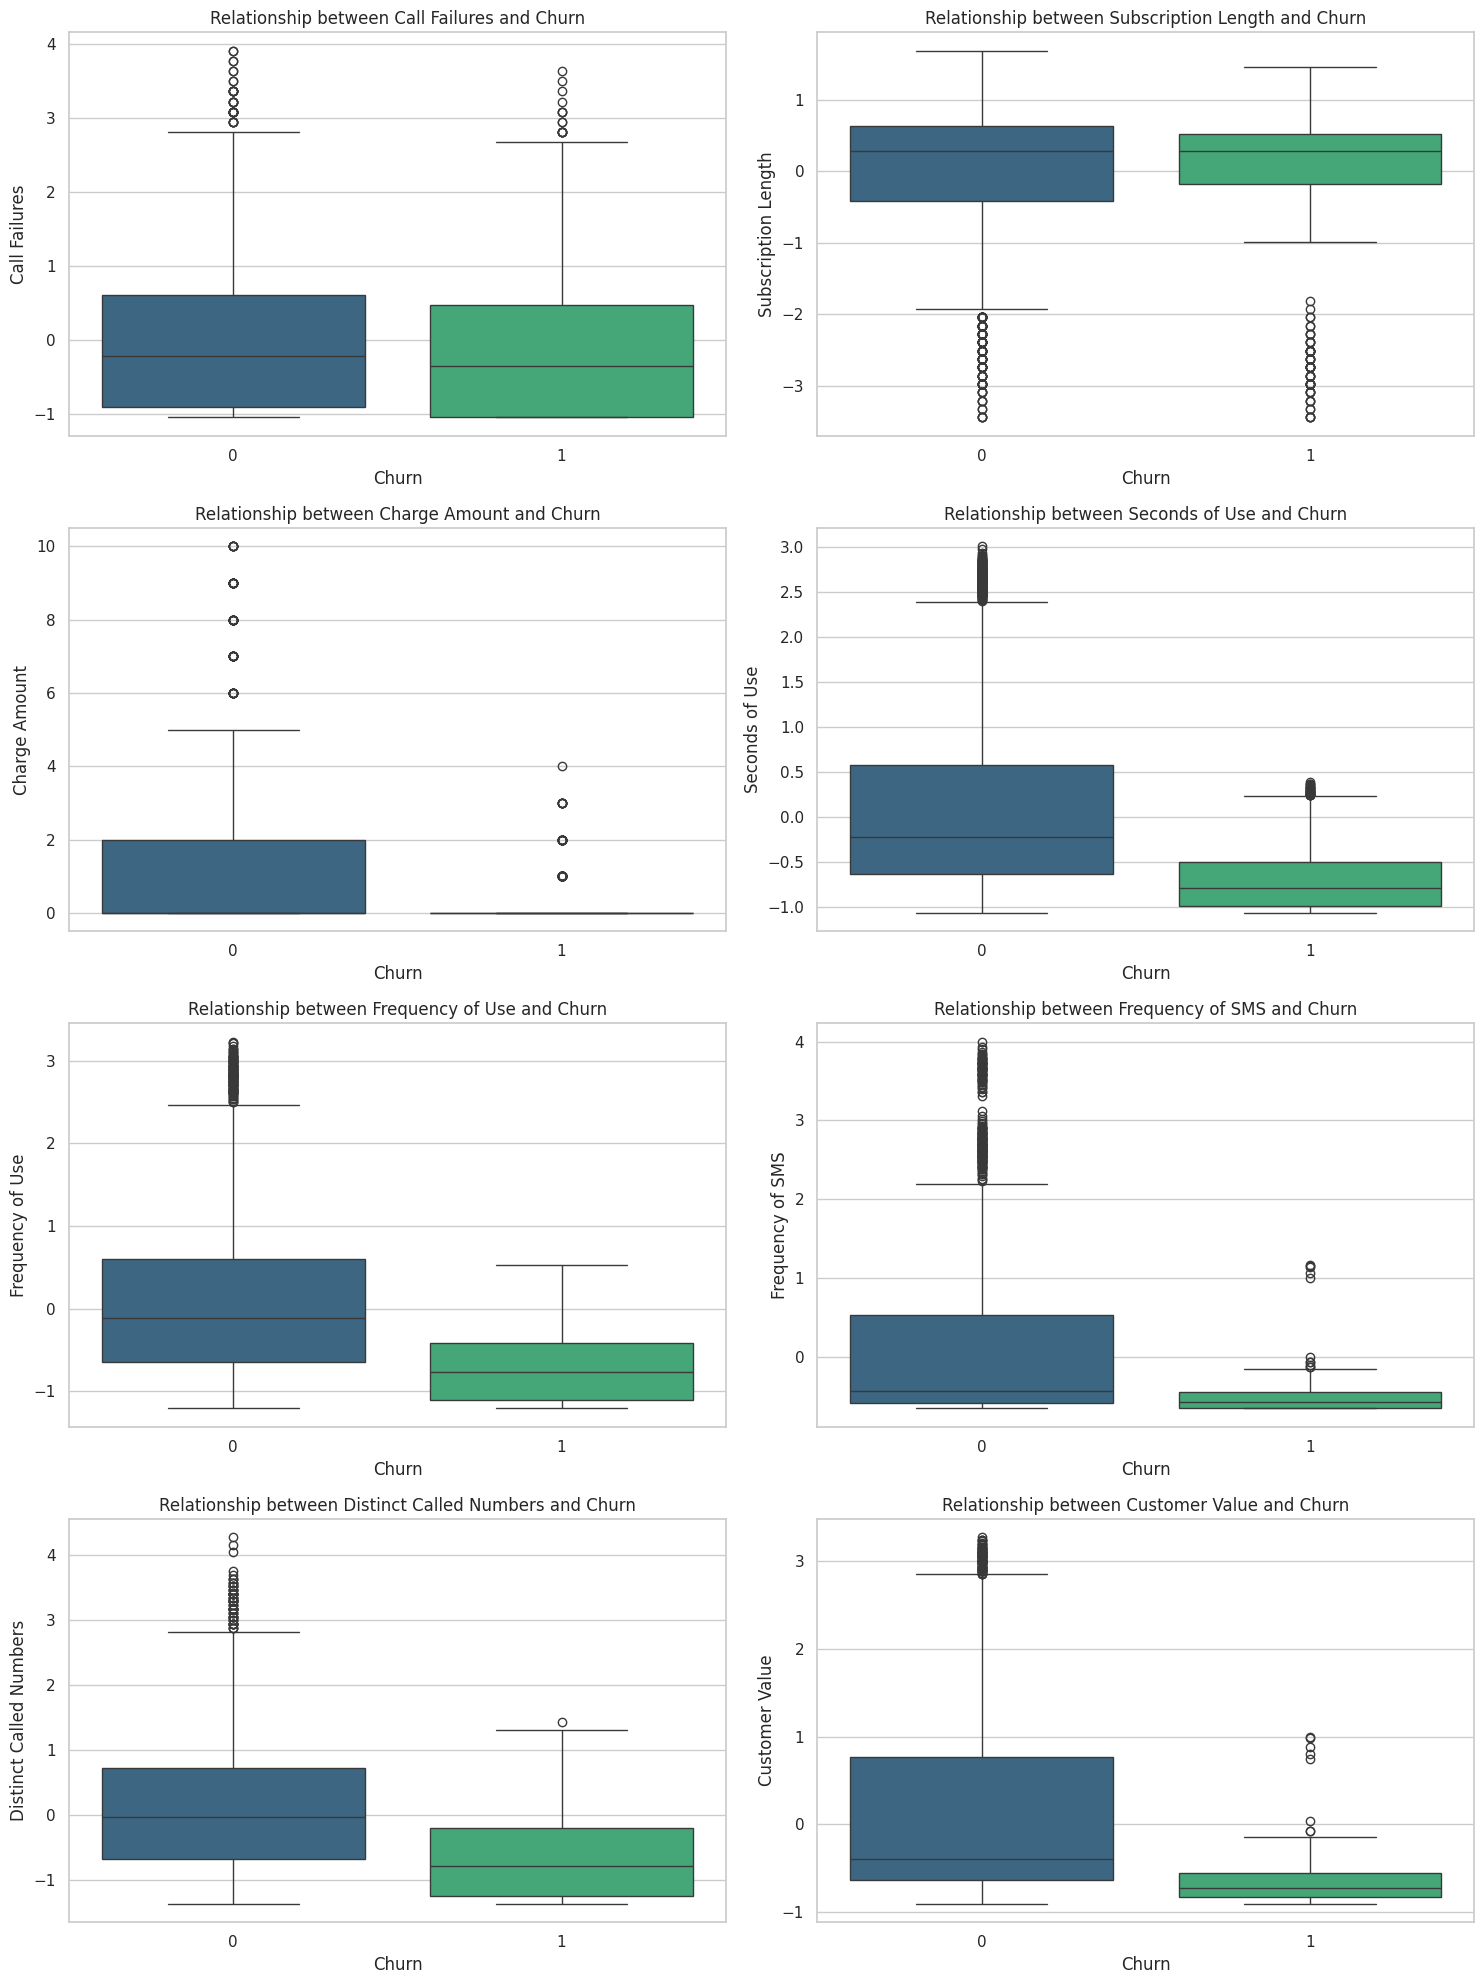

In [18]:
# Define the numerical columns
numerical_cols = ['Call Failures', 'Subscription Length', 'Charge Amount', 'Seconds of Use',
                  'Frequency of Use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']

# Determine the number of rows and columns for the subplots
n_cols = 2
n_rows = (len(numerical_cols) + 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the relationship between numerical features and Churn
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='Churn', y=col, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Relationship between {col} and Churn')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)

# Adjust layout
plt.tight_layout()
plt.show()

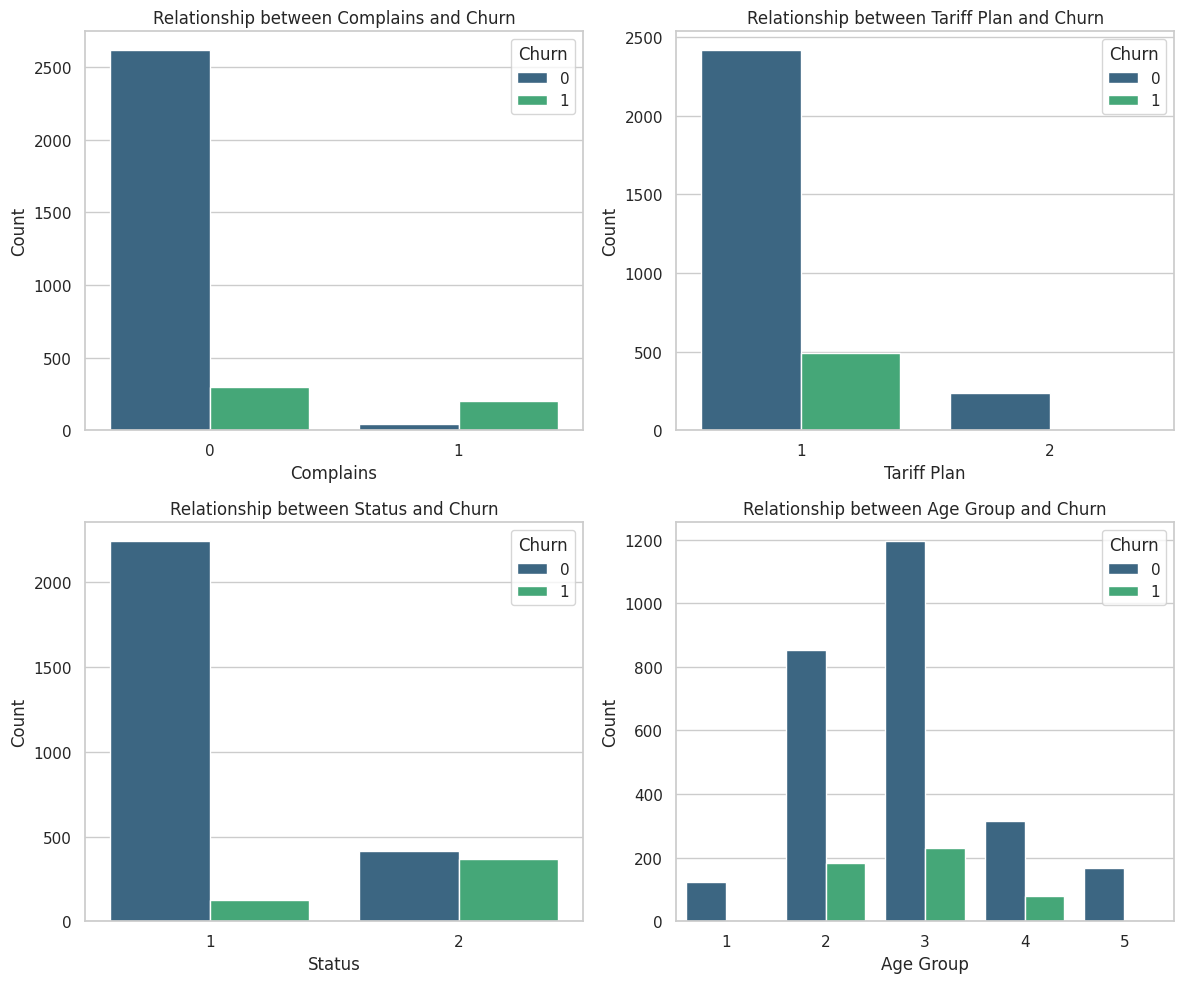

In [19]:
# Relationship between categorical features and Churn using subplots
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col != 'Churn':
        sns.countplot(data=df, x=col, hue='Churn', palette='viridis', ax=axes[i])
        axes[i].set_title(f'Relationship between {col} and Churn')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Model Implementation

For your customer churn dataset, the problem at hand is a binary classification problem where the goal is to predict whether a customer will churn (leave the service) or not based on various features. Given the nature of the problem, we can select two different machine learning algorithms: Logistic Regression and Random Forest.

Algorithm Selection and Justification
1. Logistic Regression

Justification:

Interpretability: Logistic Regression is highly interpretable, allowing us to understand the influence of each feature on the probability of churn.

Baseline Model: It serves as a good baseline model for binary classification problems. It's a linear model that can perform well with a properly preprocessed dataset.

Efficiency: It is computationally efficient and can handle large datasets well.

Probabilistic Output: Logistic Regression provides probabilistic predictions, which can be useful for understanding the certainty of predictions.
2. Random Forest

Justification:

Handling Non-Linearity: Random Forest is a powerful ensemble learning method that can capture complex relationships and interactions between features that Logistic Regression might miss.

Feature Importance: It provides insights into feature importance, helping to identify which features contribute most to predicting churn.

Robustness: It is robust to outliers and overfitting due to its ensemble nature and the use of bootstrapping.

Performance: Random Forest generally performs well on a wide range of datasets and is particularly useful when the dataset has many features and interactions.

## Logistic Regression

In [20]:
# Define the feature columns and target column
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate the model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       520
           1       0.73      0.40      0.52       110

    accuracy                           0.87       630
   macro avg       0.81      0.68      0.72       630
weighted avg       0.86      0.87      0.85       630

Confusion Matrix:
[[504  16]
 [ 66  44]]


## Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       520
           1       0.84      0.75      0.79       110

    accuracy                           0.93       630
   macro avg       0.89      0.86      0.88       630
weighted avg       0.93      0.93      0.93       630

Confusion Matrix:
[[504  16]
 [ 27  83]]


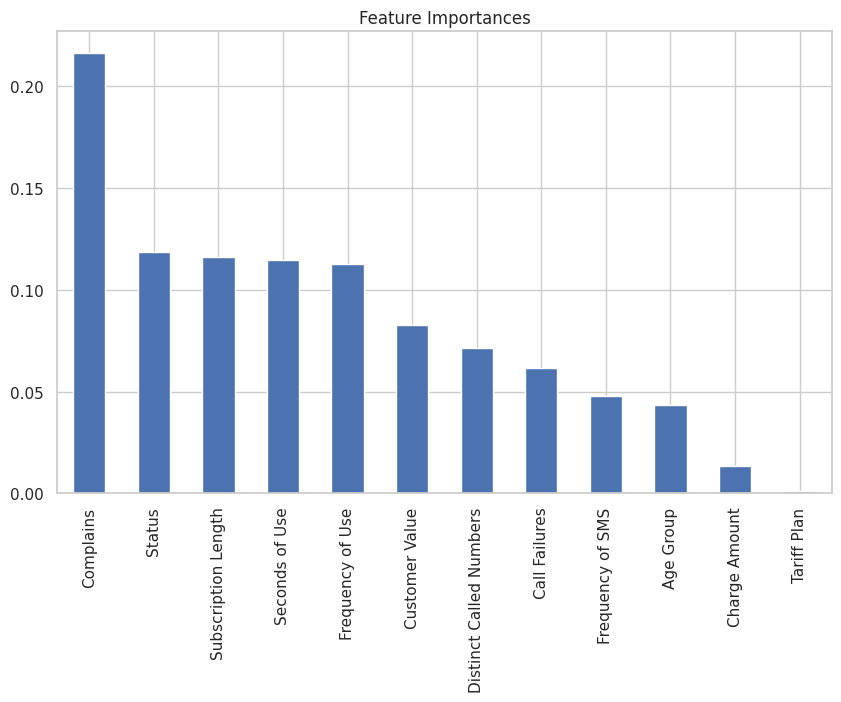

In [21]:
# Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.show()

# Gradient Boosting Machines

**Selecting Gradient Boosting Machines (GBM) for the Dataset**

Gradient Boosting Machines (GBM) are a powerful ensemble learning technique that combines the strengths of multiple weak learners, typically decision trees, to create a robust predictive model. When selecting GBM for the given dataset, several characteristics of the data and the problem make this method particularly suitable:

1. **High Dimensionality and Feature Interactions**: The dataset contains a mix of numerical and categorical features, with potential complex interactions among them. GBM excels at capturing these interactions by sequentially building trees that focus on correcting the errors of previous ones, effectively handling high-dimensional data.

2. **Handling of Mixed Data Types**: The dataset includes both numerical and categorical features. GBM can handle mixed data types efficiently without the need for extensive preprocessing like one-hot encoding for categorical variables, especially when using implementations like CatBoost or LightGBM that handle categorical features natively.

3. **Robustness to Outliers and Irrelevant Features**: GBM models are generally robust to outliers and can ignore irrelevant features, making them suitable for datasets where some features may not have a strong influence on the target variable (churn in this case).

4. **Ability to Capture Non-Linear Relationships**: The customer churn problem often involves non-linear relationships between features and the target variable. GBM is effective at capturing these non-linear patterns through its iterative process of model refinement.

5. **Good Predictive Performance**: GBM models are known for their high predictive accuracy, particularly in structured/tabular data scenarios. This makes them a strong choice when the primary goal is to maximize predictive performance, as evidenced by their success in machine learning competitions and practical applications.

6. **Control over Model Complexity**: GBM allows fine control over model complexity through hyperparameters such as the number of boosting rounds, learning rate, and tree depth. This flexibility helps in balancing bias-variance trade-offs, preventing overfitting, and tuning the model for optimal performance.

**Conclusion**: Given these characteristics, GBM is a well-suited choice for the customer churn dataset, providing a robust framework to capture complex patterns and deliver high predictive accuracy. The use of GBM can lead to better understanding and prediction of customer churn, aiding in strategic decision-making.

In [22]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Define the feature columns and target column
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       520
           1       0.88      0.79      0.83       110

    accuracy                           0.94       630
   macro avg       0.92      0.88      0.90       630
weighted avg       0.94      0.94      0.94       630

Confusion Matrix:
[[508  12]
 [ 23  87]]


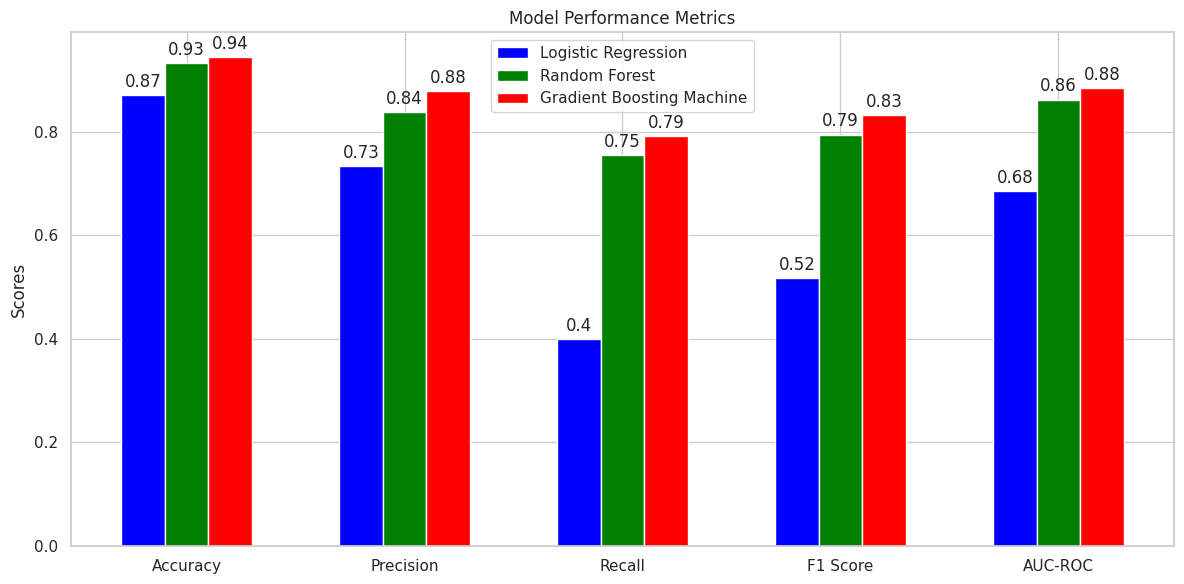

In [25]:
# Define the metrics and their values for both models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']

# Evaluate the models

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred)
    }

metrics_tuned_log_reg = evaluate_model(log_reg, X_test_scaled, y_test)
metrics_default_rf = evaluate_model(rf, X_test, y_test)
metrics_tuned_gbm = evaluate_model(xgb_model, X_test, y_test)

# Extract the metrics values
log_reg_metrics = [
    metrics_tuned_log_reg['accuracy'],
    metrics_tuned_log_reg['precision'],
    metrics_tuned_log_reg['recall'],
    metrics_tuned_log_reg['f1_score'],
    metrics_tuned_log_reg['roc_auc']
]

rf_metrics = [
    metrics_default_rf['accuracy'],
    metrics_default_rf['precision'],
    metrics_default_rf['recall'],
    metrics_default_rf['f1_score'],
    metrics_default_rf['roc_auc']
]

gbm_metrics = [
    metrics_tuned_gbm['accuracy'],
    metrics_tuned_gbm['precision'],
    metrics_tuned_gbm['recall'],
    metrics_tuned_gbm['f1_score'],
    metrics_tuned_gbm['roc_auc']
]

# Plot the metrics
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, log_reg_metrics, width, label='Logistic Regression', color='blue')
rects2 = ax.bar(x, rf_metrics, width, label='Random Forest', color='green')
rects3 = ax.bar(x + width, gbm_metrics, width, label='Gradient Boosting Machine', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

# Hyperparameter Tuning

Hyperparameter tuning is crucial for improving the performance of machine learning models. It involves finding the best combination of hyperparameters to optimize the model's performance. Here are some tips and techniques for hyperparameter tuning:

1. Understand the Hyperparameters:

Logistic Regression:

    C: Regularization strength. Lower values mean stronger regularization.

    penalty: Type of regularization (l1, l2, elasticnet, or none).

    solver: Algorithm to use for optimization (liblinear, newton-cg, lbfgs, etc.).

Random Forest:

    n_estimators: Number of trees in the forest.
    max_depth: Maximum depth of each tree.
    min_samples_split: Minimum number of samples required to split an internal node.
    min_samples_leaf: Minimum number of samples required to be at a leaf node.
    max_features: Number of features to consider when looking for the best split.
2. Choose a Tuning Method:

Grid Search:

    Exhaustively searches through a specified set of hyperparameters.
    GridSearchCV in scikit-learn allows you to define a grid of hyperparameters and evaluates all possible combinations.

Random Search:

    Randomly samples from a specified set of hyperparameters.
    Often faster than grid search, especially with many hyperparameters. Use RandomizedSearchCV in scikit-learn.

Bayesian Optimization:

    Uses probabilistic models to predict which hyperparameters might yield the best performance.
    Libraries such as Optuna, Hyperopt, and Scikit-Optimize can be used for Bayesian optimization.

Automated Machine Learning (AutoML):

    Tools like TPOT and Auto-sklearn automate the process of model selection and hyperparameter tuning.

##  Implementing Grid Search and Random Search

Grid Search for Logistic Regression

In [26]:
# Define the parameter grid for Logistic Regression
param_grid_log_reg = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # Ensure compatibility with the chosen solver
    'solver': ['liblinear', 'lbfgs']
}

# Create a GridSearchCV object
grid_search_log_reg = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_log_reg, cv=5, scoring='accuracy', error_score='raise')
grid_search_log_reg.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best parameters for Logistic Regression:", grid_search_log_reg.best_params_)
print("Best score for Logistic Regression:", grid_search_log_reg.best_score_)

Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9043650793650795


Random Search for Random Forest

In [27]:
# Define the parameter distribution for Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': [None] + list(range(10, 50, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2']  # Use 'sqrt' or 'log2' instead of 'auto'
}

# Create a RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_dist_rf, n_iter=50, cv=5, scoring='accuracy', random_state=42)
random_search_rf.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best score for Random Forest:", random_search_rf.best_score_)

Best parameters for Random Forest: {'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 196}
Best score for Random Forest: 0.9579365079365079


Grid Search for Gradient Boosting Machine

In [28]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best score: 0.9603174603174602


# Comparison of Models Before and After Hyperparameter Tuning

In [31]:
# Define the best hyperparameters found
best_params_log_reg = {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
best_params_rf = {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}

# Re-train Logistic Regression with best hyperparameters
log_reg_best = LogisticRegression(**best_params_log_reg)
log_reg_best.fit(X_train_scaled, y_train)

# Re-train Random Forest with best hyperparameters
rf_best = RandomForestClassifier(**best_params_rf)
rf_best.fit(X_train, y_train)

# Metrics for default models
metrics_default_log_reg = evaluate_model(log_reg, X_test_scaled, y_test)
metrics_default_rf = evaluate_model(rf, X_test, y_test)
metrics_default_gbm = evaluate_model(xgb_model, X_test, y_test)

# Metrics for tuned models
metrics_tuned_log_reg = evaluate_model(log_reg_best, X_test_scaled, y_test)
metrics_tuned_rf = evaluate_model(rf_best, X_test, y_test)
metrics_tuned_gbm = evaluate_model(grid_search, X_test, y_test)

# Print the metrics for comparison
print("Logistic Regression - Default Hyperparameters:")
print(metrics_default_log_reg)
print("\nRandom Forest - Default Hyperparameters:")
print(metrics_default_rf)
print("\nGradient Boosting Machine - Default Hyperparameters:")
print(metrics_default_gbm)

print("\nLogistic Regression - Tuned Hyperparameters:")
print(metrics_tuned_log_reg)
print("\nRandom Forest - Tuned Hyperparameters:")
print(metrics_tuned_rf)
print("\nGradient Boosting Machine - Tuned Hyperparameters:")
print(metrics_tuned_gbm)

Logistic Regression - Default Hyperparameters:
{'accuracy': 0.8698412698412699, 'precision': 0.7333333333333333, 'recall': 0.4, 'f1_score': 0.5176470588235295, 'roc_auc': 0.6846153846153846}

Random Forest - Default Hyperparameters:
{'accuracy': 0.9317460317460318, 'precision': 0.8383838383838383, 'recall': 0.7545454545454545, 'f1_score': 0.7942583732057416, 'roc_auc': 0.8618881118881118}

Gradient Boosting Machine - Default Hyperparameters:
{'accuracy': 0.9444444444444444, 'precision': 0.8787878787878788, 'recall': 0.7909090909090909, 'f1_score': 0.8325358851674641, 'roc_auc': 0.883916083916084}

Logistic Regression - Tuned Hyperparameters:
{'accuracy': 0.8809523809523809, 'precision': 0.8571428571428571, 'recall': 0.38181818181818183, 'f1_score': 0.5283018867924528, 'roc_auc': 0.6841783216783217}

Random Forest - Tuned Hyperparameters:
{'accuracy': 0.9317460317460318, 'precision': 0.8602150537634409, 'recall': 0.7272727272727273, 'f1_score': 0.7881773399014779, 'roc_auc': 0.851136363

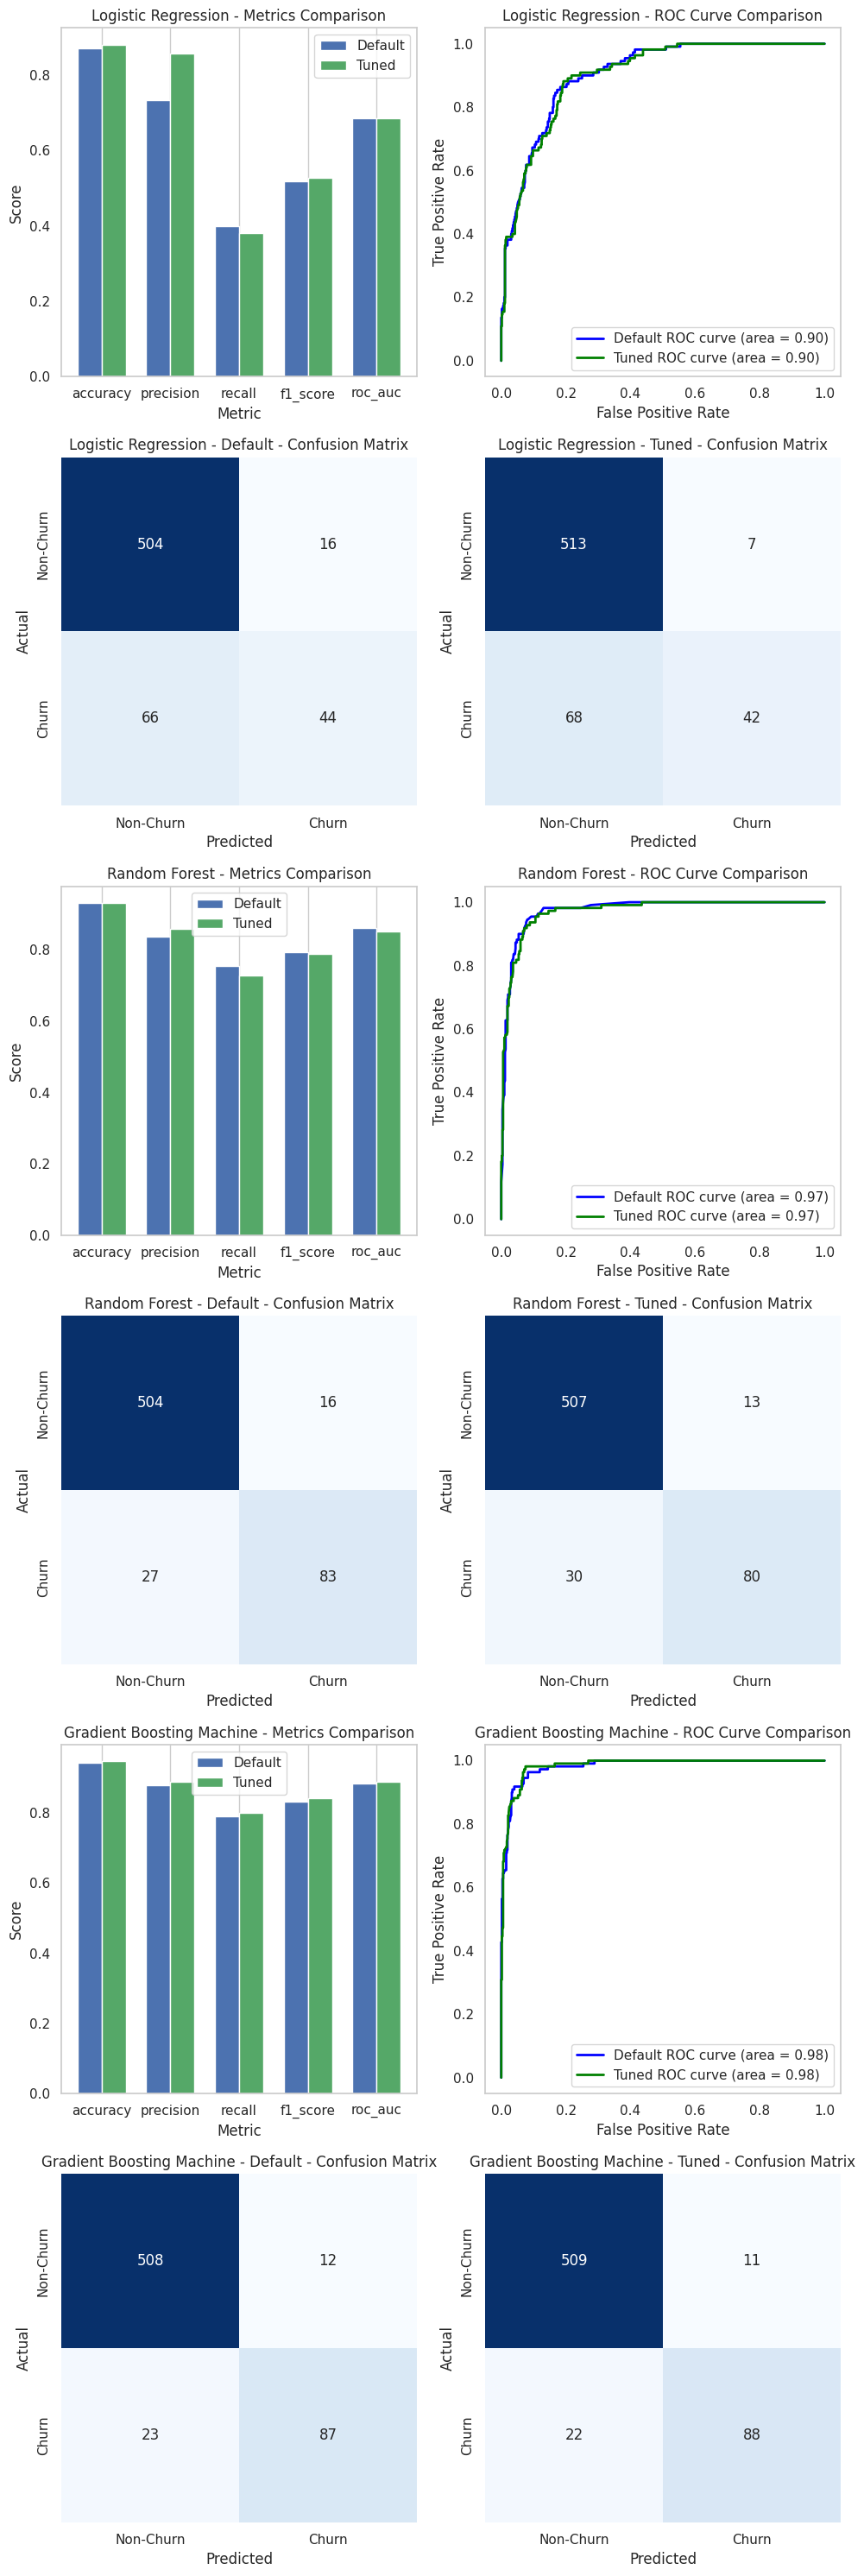

In [33]:
# Define a function to plot model performance metrics
def plot_metrics_comparison(metrics_default, metrics_tuned, model_name, ax):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    default_values = [metrics_default[metric] for metric in metrics]
    tuned_values = [metrics_tuned[metric] for metric in metrics]

    index = np.arange(len(metrics))
    bar_width = 0.35

    bars1 = ax.bar(index, default_values, bar_width, label='Default', color='b')
    bars2 = ax.bar(index + bar_width, tuned_values, bar_width, label='Tuned', color='g')

    ax.set_xlabel('Metric')
    ax.set_ylabel('Score')
    ax.set_title(f'{model_name} - Metrics Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(axis='y')

# Define a function to plot ROC Curves
def plot_roc_curve(model_default, model_tuned, X_test, y_test, model_name, ax):
    # ROC curve for default model
    y_prob_default = model_default.predict_proba(X_test)[:, 1]
    fpr_default, tpr_default, _ = roc_curve(y_test, y_prob_default)
    auc_default = roc_auc_score(y_test, y_prob_default)

    # ROC curve for tuned model
    y_prob_tuned = model_tuned.predict_proba(X_test)[:, 1]
    fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
    auc_tuned = roc_auc_score(y_test, y_prob_tuned)

    ax.plot(fpr_default, tpr_default, color='blue', lw=2, label=f'Default ROC curve (area = {auc_default:.2f})')
    ax.plot(fpr_tuned, tpr_tuned, color='green', lw=2, label=f'Tuned ROC curve (area = {auc_tuned:.2f})')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - ROC Curve Comparison')
    ax.legend(loc='lower right')
    ax.grid()

# Define a function to plot confusion matrices
def plot_confusion_matrix(cm, model_name, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
    ax.set_title(f'{model_name} - Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Metrics and confusion matrices for Logistic Regression
metrics_default_log_reg = evaluate_model(log_reg, X_test_scaled, y_test)
metrics_tuned_log_reg = evaluate_model(log_reg_best, X_test_scaled, y_test)
cm_default_log_reg = confusion_matrix(y_test, y_pred_log_reg)
cm_tuned_log_reg = confusion_matrix(y_test, log_reg_best.predict(X_test_scaled))

# Metrics and confusion matrices for Random Forest
metrics_default_rf = evaluate_model(rf, X_test, y_test)
metrics_tuned_rf = evaluate_model(rf_best, X_test, y_test)
cm_default_rf = confusion_matrix(y_test, y_pred_rf)
cm_tuned_rf = confusion_matrix(y_test, rf_best.predict(X_test))

# Metrics and confusion matrices for Gradient Boosting Machine
metrics_default_gb = evaluate_model(xgb_model, X_test, y_test)
metrics_tuned_gb = evaluate_model(grid_search, X_test, y_test)
cm_default_gb = confusion_matrix(y_test, xgb_model.predict(X_test))
cm_tuned_gb = confusion_matrix(y_test, grid_search.predict(X_test))

# Create subplots for comparisons
fig, axs = plt.subplots(6, 2, figsize=(10, 30))

# Plot metrics for Logistic Regression
plot_metrics_comparison(metrics_default_log_reg, metrics_tuned_log_reg, 'Logistic Regression', axs[0, 0])

# Confusion Matrix for Logistic Regression
plot_confusion_matrix(cm_default_log_reg, 'Logistic Regression - Default', axs[1, 0])
plot_confusion_matrix(cm_tuned_log_reg, 'Logistic Regression - Tuned', axs[1, 1])

# ROC Curve for Logistic Regression
plot_roc_curve(log_reg, log_reg_best, X_test_scaled, y_test, 'Logistic Regression', axs[0, 1])

# Plot metrics for Random Forest
plot_metrics_comparison(metrics_default_rf, metrics_tuned_rf, 'Random Forest', axs[2, 0])

# Confusion Matrix for Random Forest
plot_confusion_matrix(cm_default_rf, 'Random Forest - Default', axs[3, 0])
plot_confusion_matrix(cm_tuned_rf, 'Random Forest - Tuned', axs[3, 1])

# ROC Curve for Random Forest
plot_roc_curve(rf, rf_best, X_test, y_test, 'Random Forest', axs[2, 1])

# Plot metrics for Gradient Boosting Machine
plot_metrics_comparison(metrics_default_gb, metrics_tuned_gb, 'Gradient Boosting Machine', axs[4, 0])

# Confusion Matrix for Gradient Boosting Machine
plot_confusion_matrix(cm_default_gb, 'Gradient Boosting Machine - Default', axs[5, 0])
plot_confusion_matrix(cm_tuned_gb, 'Gradient Boosting Machine - Tuned', axs[5, 1])

# ROC Curve for Gradient Boosting Machine
plot_roc_curve(xgb_model, grid_search, X_test, y_test, 'Gradient Boosting Machine', axs[4, 1])

# Adjust layout and show
plt.tight_layout()
plt.show()

In [34]:
# Compare and print the best model for each type based on the highest metric scores
def print_best_model(metrics_default, metrics_tuned, model_name):
    best_model = {}
    for metric in metrics_default.keys():
        if metrics_tuned[metric] > metrics_default[metric]:
            best_model[metric] = ('Tuned', metrics_tuned[metric])
        else:
            best_model[metric] = ('Default', metrics_default[metric])
    print(f"\nBest {model_name} Model based on each metric:")
    for metric, (model_type, score) in best_model.items():
        print(f"{metric}: {model_type} ({score:.4f})")

# Print the best model for Logistic Regression
print_best_model(metrics_default_log_reg, metrics_tuned_log_reg, 'Logistic Regression')

# Print the best model for Random Forest
print_best_model(metrics_default_rf, metrics_tuned_rf, 'Random Forest')

# Print the best model for Gradient Boosting Machine
print_best_model(metrics_default_gbm, metrics_tuned_gbm, 'Gradient Boosting Machine')


Best Logistic Regression Model based on each metric:
accuracy: Tuned (0.8810)
precision: Tuned (0.8571)
recall: Default (0.4000)
f1_score: Tuned (0.5283)
roc_auc: Default (0.6846)

Best Random Forest Model based on each metric:
accuracy: Default (0.9317)
precision: Tuned (0.8602)
recall: Default (0.7545)
f1_score: Default (0.7943)
roc_auc: Default (0.8619)

Best Gradient Boosting Machine Model based on each metric:
accuracy: Tuned (0.9476)
precision: Tuned (0.8889)
recall: Tuned (0.8000)
f1_score: Tuned (0.8421)
roc_auc: Tuned (0.8894)


Random Forest with Default Hyperparameters, Logistic Regression with Tuned Hyperparameters, and Gradient Boosting Machine - Tuned Hyperparameters are the best as of now.


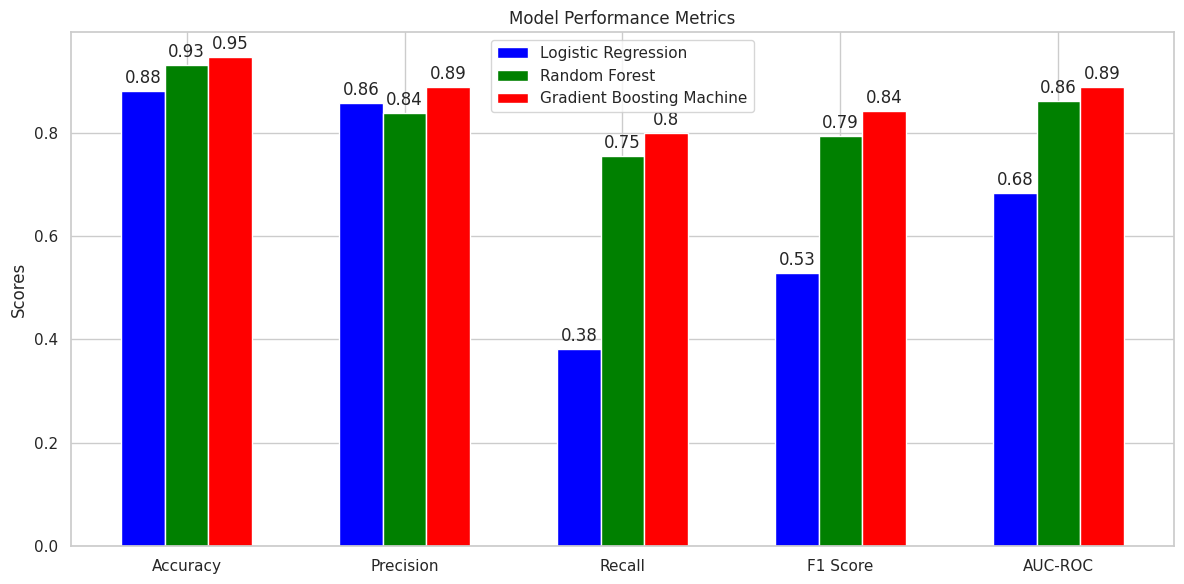

In [35]:
# Define the metrics and their values for both models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']

# Evaluate the models
metrics_tuned_log_reg = evaluate_model(log_reg_best, X_test_scaled, y_test)
metrics_default_rf = evaluate_model(rf, X_test, y_test)
metrics_tuned_gbm = evaluate_model(grid_search, X_test, y_test)

# Extract the metrics values
log_reg_metrics = [
    metrics_tuned_log_reg['accuracy'],
    metrics_tuned_log_reg['precision'],
    metrics_tuned_log_reg['recall'],
    metrics_tuned_log_reg['f1_score'],
    metrics_tuned_log_reg['roc_auc']
]

rf_metrics = [
    metrics_default_rf['accuracy'],
    metrics_default_rf['precision'],
    metrics_default_rf['recall'],
    metrics_default_rf['f1_score'],
    metrics_default_rf['roc_auc']
]

gbm_metrics = [
    metrics_tuned_gbm['accuracy'],
    metrics_tuned_gbm['precision'],
    metrics_tuned_gbm['recall'],
    metrics_tuned_gbm['f1_score'],
    metrics_tuned_gbm['roc_auc']
]

# Plot the metrics
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, log_reg_metrics, width, label='Logistic Regression', color='blue')
rects2 = ax.bar(x, rf_metrics, width, label='Random Forest', color='green')
rects3 = ax.bar(x + width, gbm_metrics, width, label='Gradient Boosting Machine', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

# 1. Model Performance Comparison

Logistic Regression showed limited improvement with hyperparameter tuning, especially in recall and F1 score. Its performance in distinguishing churn (as indicated by recall) is relatively lower compared to other models.

Random Forest provided good performance with a high recall and F1 score, indicating a good balance between precision and recall. However, hyperparameter tuning resulted in only marginal improvements.

Gradient Boosting Machine (GBM) emerged as the best-performing model across almost all metrics. The improvement from default to tuned hyperparameters is noticeable, particularly in accuracy, precision, and F1 score.

Based on these metrics, the Gradient Boosting Machine model, particularly after hyperparameter tuning, is the most effective for the given problem of predicting customer churn. It provides the best balance of precision, recall, and overall accuracy, making it a reliable choice for the task.

# 2. Challenges Faced and Solutions
Hyperparameter Tuning: One of the main challenges was tuning the hyperparameters to improve model performance. This process can be time-consuming and requires careful consideration of different parameter combinations. We used GridSearchCV, which systematically searches over the specified parameter grid, to address this challenge.

Class Imbalance: Churn prediction often involves an imbalanced dataset, where the number of non-churn cases significantly outweighs the churn cases. This can lead to models that are biased towards the majority class. We addressed this by focusing on metrics like precision, recall, and AUC-ROC, which provide a better understanding of the model's performance on both classes.

Computational Resources and Time: Training and tuning complex models like Random Forest and GBM can be computationally expensive and time-consuming, especially with large datasets or many hyperparameters. Efficient use of resources and parallel processing (where possible) helped mitigate this challenge.

Data Preprocessing: Proper handling of missing values, feature scaling, and encoding of categorical variables were essential to ensure the models performed well. This required careful preprocessing steps and validation to ensure data integrity and model accuracy.